In [1]:
import numpy as np, matplotlib.pyplot as plt
from skimage import io, color
from PIL import Image
import itertools

In [2]:
BLOCK_SIZE = 32

def crop_img(img):
    new_height = img.shape[0] - img.shape[0] % BLOCK_SIZE
    
    new_width = img.shape[1] - img.shape[1] % BLOCK_SIZE
    return img[:new_height,:new_width,:]

def split_img(img):
    assert img.shape[0] % BLOCK_SIZE == 0 and img.shape[1] % BLOCK_SIZE == 0
    split0 = np.split(img, img.shape[0] // BLOCK_SIZE, axis=0)
    result = []
    for x in split0:
        result += np.split(x, img.shape[1] // BLOCK_SIZE, axis=1)
    return result

def dissimilarity(e1, e2):
    return np.sqrt(np.sum((e1 - e2) ** 2))

(1024, 1024, 3)
(1024, 1024, 3)
1024 pieces


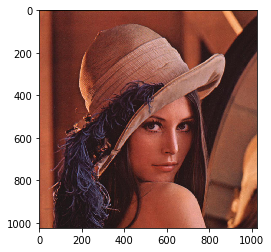

In [3]:
image_path = 'images/lenna.jpg'
rgb = crop_img(io.imread(image_path))
lab = color.rgb2lab(rgb)
plt.imshow(rgb)

pieces = split_img(lab)
N = len(pieces)
puzzle_height = lab.shape[0] // BLOCK_SIZE
puzzle_width = lab.shape[1] // BLOCK_SIZE
print('{} pieces'.format(len(pieces)))
right_dissimilarity = np.zeros((N, N))
down_dissimilarity = np.zeros((N, N))
for i, p1 in enumerate(pieces):
    for j, p2 in enumerate(pieces):
        right_dissimilarity[i,j] = dissimilarity(p1[:,-1], p2[:,0])
        down_dissimilarity[i,j] = dissimilarity(p1[-1,:], p2[0,:])
np.fill_diagonal(right_dissimilarity, np.inf)
np.fill_diagonal(down_dissimilarity, np.inf)

In [4]:
best_left = np.argmin(right_dissimilarity, axis=0)
best_right = np.argmin(right_dissimilarity, axis=1)
bb_left = [x if best_right[x] == i else None for i, x in enumerate(best_left)]
bb_right = [x if best_left[x] == i else None for i, x in enumerate(best_right)]
best_up = np.argmin(down_dissimilarity, axis=0)
best_down = np.argmin(down_dissimilarity, axis=1)
bb_up = [x if best_down[x] == i else None for i, x in enumerate(best_up)]
bb_down = [x if best_up[x] == i else None for i, x in enumerate(best_down)]

In [12]:
from enum import Enum
class Direction(Enum):
    RIGHT = 0
    DOWN = 1
    LEFT = 2
    UP = 3
    def move(self, pt):
        if self == Direction.RIGHT:
            return pt[0], pt[1] + 1
        if self == Direction.DOWN:
            return pt[0] + 1, pt[1]
        if self == Direction.LEFT:
            return pt[0], pt[1] - 1
        if self == Direction.UP:
            return pt[0] - 1, pt[1]
        raise ValueError()
    def move_reverse(self, pt):
        return Direction((self.value + 2) % 4).move(pt)

def get_random_parent():
    result = -np.ones((puzzle_height + 2, puzzle_width + 2), dtype=int)
    result[1:-1,1:-1] = np.random.choice(N, (puzzle_height, puzzle_width), replace=False)
    return result

def crossover(parent1, parent2, parent1_start, parent2_start):
    parent1_loc = [None] * N
    parent2_loc = [None] * N
    child_loc = [None] * N
    for i in range(puzzle_height):
        for j in range(puzzle_width):
            a = i + parent1_start[0], j + parent1_start[1]
            b = i + parent2_start[0], j + parent2_start[1]
            parent1_loc[parent1[a]] = a
            parent2_loc[parent2[b]] = b
    
    child = -np.ones((puzzle_height * 2 + 1, puzzle_width * 2 + 1))
    placed = [False] * N
    p = np.random.randint(0, N)
    placed[p] = True
    child[puzzle_height, puzzle_width] = p
    child_loc[p] = puzzle_height, puzzle_width
    min_i = max_i = puzzle_height
    min_j = max_j = puzzle_width
    # location of empty slot => (direction from existing slot to empty slot, piece number of existing slot)
    boundaries = {d.move((puzzle_height, puzzle_width)): (d, p) for d in Direction}
    
    def helper(i, j, p):
        nonlocal min_i, max_i, min_j, max_j
        child[i, j] = p
        child_loc[p] = i, j
        placed[p] = True
        min_i = min(min_i, i)
        max_i = max(max_i, i)
        min_j = min(min_j, j)
        max_j = max(max_j, j)
        dirs = []
        if max_i - i < puzzle_height - 1:
            dirs.append(Direction.UP)
        if i - min_i < puzzle_height - 1:
            dirs.append(Direction.DOWN)
        if max_j - j < puzzle_width - 1:
            dirs.append(Direction.LEFT)
        if j - min_j < puzzle_width - 1:
            dirs.append(Direction.RIGHT)
        del boundaries[i, j]
        for d2 in dirs:
            new_empty = d2.move((i, j))
            if child[new_empty] < 0 and new_empty not in boundaries:
                boundaries[new_empty] = (d2, p)
                
    while boundaries:
        for (i, j), (d, p) in boundaries.items():
            p1_l = parent1_loc[p]
            p2_l = parent2_loc[p]
            loc1 = d.move(p1_l)
            loc2 = d.move(p2_l)
            p1 = parent1[loc1]
            p2 = parent2[loc2]
            if p1 >= 0 and p1 == p2 and not placed[p1]:
                helper(i, j, p1)
                break
                
        # TODO
        for (i, j), (d, p) in boundaries.items():
            pass
        
        # TODO
        for (i, j), (d, p) in boundaries.items():
            pass
            
#     for p in unplaced:
#         i1, j1 = parent1_loc[p]
#         i2, j2 = parent2_loc[p]
#         right1 = i1, j1 + 1
#         right2 = i2, j2 + 1
#         c = parent1[right1]
#         if c >= 0 and c == parent2[right2]:
#             child[min_i, min_j] = p
#             child[min_i, min_j + 1] = c
#             max_j += 1
#             unplaced.remove(p)
#             unplaced.remove(c)
#             break
#         down1 = i1 + 1, j1
#         down2 = i2 + 1, j2
#         c = parent1[down1]
#         if c >= 0 and c == parent2[down2]:
#             child[min_i, min_j] = p
#             child[min_i + 1, min_j] = c
#             max_i += 1
#             unplaced.remove(p)
#             unplaced.remove(c)
#             break
#     else:
#         # found no parent agreements
    
        
            
    return child

print(crossover(get_random_parent(), get_random_parent(), (1, 1), (1, 1)))

KeyboardInterrupt: 